<a href="https://colab.research.google.com/github/RH00000/UH_RTS_Research_ML/blob/main/full_simulation_gridsearch_0.0_to_0.95_shared_conf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload the profiling NPZ file from local machine (Colab)
from google.colab import files
uploaded = files.upload()

Saving abcd_profiling_validation_stats.npz to abcd_profiling_validation_stats.npz


In [2]:
# 1: Load profiling data
import numpy as np
import pandas as pd

data = np.load('abcd_profiling_validation_stats.npz')  # uses the uploaded file
confs = data['confs']    # shape (N,4)
times = data['times']    # shape (N,4)
oks   = data['oks']      # shape (N,4), bool
N, M = confs.shape       # N samples, M=4 models (A,B,C,D)

In [3]:
def simulate_cascade(confs, times, oks,
                     thr_a, thr_b, thr_c,
                     skip_b_thresh, skip_c_thresh):
    total_time     = 0.0
    correct        = 0
    skip_c_count   = 0
    skip_bc_count  = 0
    skip_b_to_c_count    = 0

    for j in range(N):
        # run A
        conf_a = confs[j,0]; t_a = times[j,0]; ok_a = oks[j,0]
        if conf_a >= thr_a:
            total_time += t_a
            correct    += ok_a
            continue

        # skip B?
        skip_b = (conf_a < skip_b_thresh)
        if not skip_b:
            # run B
            total_time += times[j,1]
            conf_b     = confs[j,1]
            ok_b       = oks[j,1]
            if conf_b >= thr_b:
                correct += ok_b
                continue
        else:
            conf_b = None

        # Decide skip C using conf_a if B skipped, else conf_b
        if skip_b:
            metric_for_c = conf_a
        else:
            metric_for_c = conf_b
        skip_c = (metric_for_c < skip_c_thresh)

        # increment appropriate counters
        if skip_b and not skip_c:
            skip_b_to_c_count += 1
        if skip_c and not skip_b:
            skip_c_count += 1
        if skip_b and skip_c:
            skip_bc_count += 1

        if not skip_c:
            # run C
            total_time += times[j,2]
            conf_c     = confs[j,2]
            ok_c       = oks[j,2]
            if conf_c >= thr_c:
                correct += ok_c
                continue

        # fallback D
        total_time += times[j,3]
        correct    += oks[j,3]

    Nf = float(N)
    return (
      correct / Nf,
      total_time / Nf,
      skip_c_count  / Nf,
      skip_bc_count / Nf,
      skip_b_to_c_count   / Nf   # NEW return value
    )

In [4]:
# 3: Define grid of thresholds to search
# np.linspace(start, end, num) generates 'num' evenly spaced values from start to end (inclusive).
# For example, np.linspace(0.5, 0.9, 5) produces [0.5, 0.6, 0.7, 0.8, 0.9].
# Step 3: Define grid of thresholds to search
# Use np.arange(start, stop, step) to generate values with a specific increment.
shared_thrs = np.arange(0.0, 0.951, 0.05) # [0.70,0.75,0.80,0.85,0.90,0.95]
# Skip thresholds
skip_bs = np.arange(0.10, 0.951, 0.05) # [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
skip_cs = np.arange(0.10, 0.951, 0.05)

In [5]:
# 4: Grid search over all combinations
records = []
total_iters = len(shared_thrs) * len(skip_bs) * len(skip_cs)
iter_count = 0

for shared_thr in shared_thrs:
    # set all three IDK thresholds to the same value
    thr_a = thr_b = thr_c = shared_thr

    for skip_b in skip_bs:
        for skip_c in skip_cs:
            # simulate with these five parameters
            acc, t, r_c, r_bc, r_b_to_c = simulate_cascade(
                confs, times, oks,
                thr_a, thr_b, thr_c,
                skip_b, skip_c
            )
            records.append({
                'shared_thr':    shared_thr,
                'skip_b_thresh': skip_b,
                'skip_c_thresh': skip_c,
                'accuracy':      acc,
                'avg_time':      t,
                'skip_C→D_rate':      r_c,
                'skip_B,C→D_rate':    r_bc,
                'skip_B→C_rate':      r_b_to_c,
            })

            # Light logging every 1000 simulations
            iter_count += 1
            if iter_count % 1000 == 0:
                print(f"Completed {iter_count}/{total_iters} grid points")

Completed 1000/6480 grid points
Completed 2000/6480 grid points
Completed 3000/6480 grid points
Completed 4000/6480 grid points
Completed 5000/6480 grid points
Completed 6000/6480 grid points


In [11]:
# 5: Analyze results
# Convert to DataFrame for easy sorting/filtering
df = pd.DataFrame(records)
# Filter by accuracy, sort by average time
target_accuracy = 0.79
best = df[df['accuracy'] >= target_accuracy].sort_values('avg_time').head(10)
print(best)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
4431        0.65           0.70           0.25    0.7900  0.009636   
4503        0.65           0.90           0.25    0.7900  0.009636   
4521        0.65           0.95           0.25    0.7900  0.009636   
4449        0.65           0.75           0.25    0.7900  0.009636   
4467        0.65           0.80           0.25    0.7900  0.009636   
4413        0.65           0.65           0.25    0.7900  0.009636   
4485        0.65           0.85           0.25    0.7900  0.009636   
4448        0.65           0.75           0.20    0.7904  0.009727   
4466        0.65           0.80           0.20    0.7904  0.009727   
4430        0.65           0.70           0.20    0.7904  0.009727   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
4431            0.0           0.0704         0.2864  
4503            0.0           0.0704         0.2864  
4521            0.0           0.0704         0.2864  
4449         

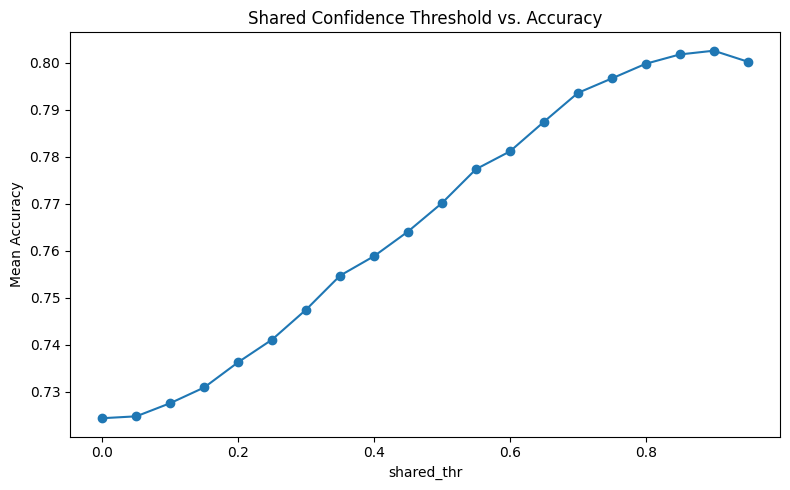

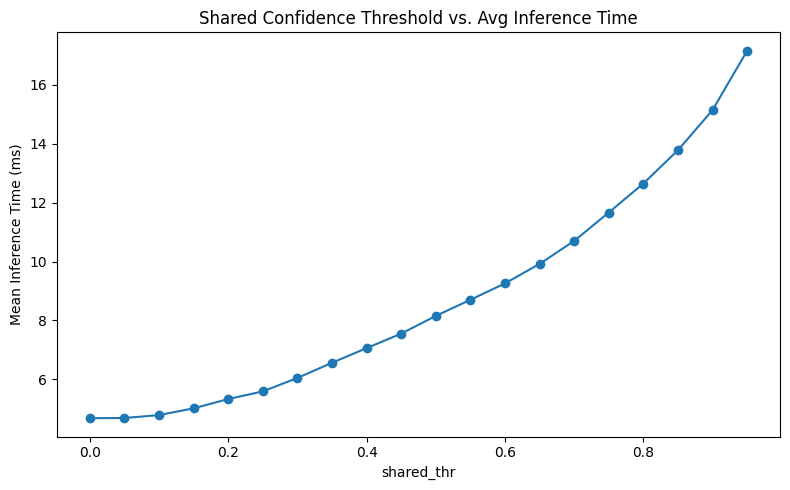

In [8]:
# Analyze why we should use higher confidence thresholds for Models ABC.

import matplotlib.pyplot as plt

# 1. Aggregate metrics by shared_thr
#    assumes your DataFrame df has columns: 'shared_thr', 'accuracy', 'avg_time'
agg = df.groupby('shared_thr').agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_time=('avg_time', 'mean')
).reset_index()
agg['mean_time_ms'] = agg['mean_time'] * 1000

# 2. Plot shared_thr vs. Accuracy
plt.figure(figsize=(8, 5))
plt.plot(agg['shared_thr'], agg['mean_accuracy'], marker='o')
plt.xlabel('shared_thr')
plt.ylabel('Mean Accuracy')
plt.title('Shared Confidence Threshold vs. Accuracy')
plt.tight_layout()
plt.show()

# 3. Plot shared_thr vs. Avg Inference Time
plt.figure(figsize=(8, 5))
plt.plot(agg['shared_thr'], agg['mean_time_ms'], marker='o')
plt.xlabel('shared_thr')
plt.ylabel('Mean Inference Time (ms)')
plt.title('Shared Confidence Threshold vs. Avg Inference Time')
plt.tight_layout()
plt.show()


In [13]:
# Filter by confidence threshold, sort by average time
target_conf_threshold = 0.65
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
4342        0.65           0.45           0.30    0.7844  0.009510   
4378        0.65           0.55           0.30    0.7868  0.009515   
4341        0.65           0.45           0.25    0.7848  0.009516   
4377        0.65           0.55           0.25    0.7872  0.009524   
4360        0.65           0.50           0.30    0.7856  0.009536   
4324        0.65           0.40           0.30    0.7844  0.009540   
4359        0.65           0.50           0.25    0.7860  0.009545   
4343        0.65           0.45           0.35    0.7848  0.009550   
4323        0.65           0.40           0.25    0.7848  0.009551   
4396        0.65           0.60           0.30    0.7876  0.009574   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
4342         0.0104           0.1020         0.1056  
4378         0.0048           0.1020         0.1824  
4341         0.0056           0.0704         0.1372  
4377         

In [14]:
target_conf_threshold = 0.85
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
5789        0.85           0.85           0.65    0.8016  0.012817   
5825        0.85           0.95           0.65    0.8016  0.012817   
5807        0.85           0.90           0.65    0.8016  0.012817   
5790        0.85           0.85           0.70    0.8020  0.012832   
5808        0.85           0.90           0.70    0.8020  0.012832   
5826        0.85           0.95           0.70    0.8020  0.012832   
5806        0.85           0.90           0.60    0.8020  0.012841   
5788        0.85           0.85           0.60    0.8020  0.012841   
5824        0.85           0.95           0.60    0.8020  0.012841   
5771        0.85           0.80           0.65    0.8016  0.012851   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
5789         0.0000           0.3568         0.1720  
5825         0.0000           0.3568         0.1720  
5807         0.0000           0.3568         0.1720  
5790         

In [16]:
target_conf_threshold = 0.95
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
6440        0.95           0.85           0.80    0.8000  0.014852   
6441        0.95           0.85           0.85    0.8000  0.014871   
6442        0.95           0.85           0.90    0.8000  0.014898   
6476        0.95           0.95           0.80    0.7996  0.014928   
6458        0.95           0.90           0.80    0.8000  0.014941   
6443        0.95           0.85           0.95    0.8004  0.014952   
6423        0.95           0.80           0.85    0.8000  0.014963   
6477        0.95           0.95           0.85    0.7996  0.014965   
6422        0.95           0.80           0.80    0.8000  0.014981   
6459        0.95           0.90           0.85    0.8000  0.014983   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
6440         0.0288           0.4824         0.0464  
6441         0.0368           0.5288         0.0000  
6442         0.0452           0.5288         0.0000  
6476         

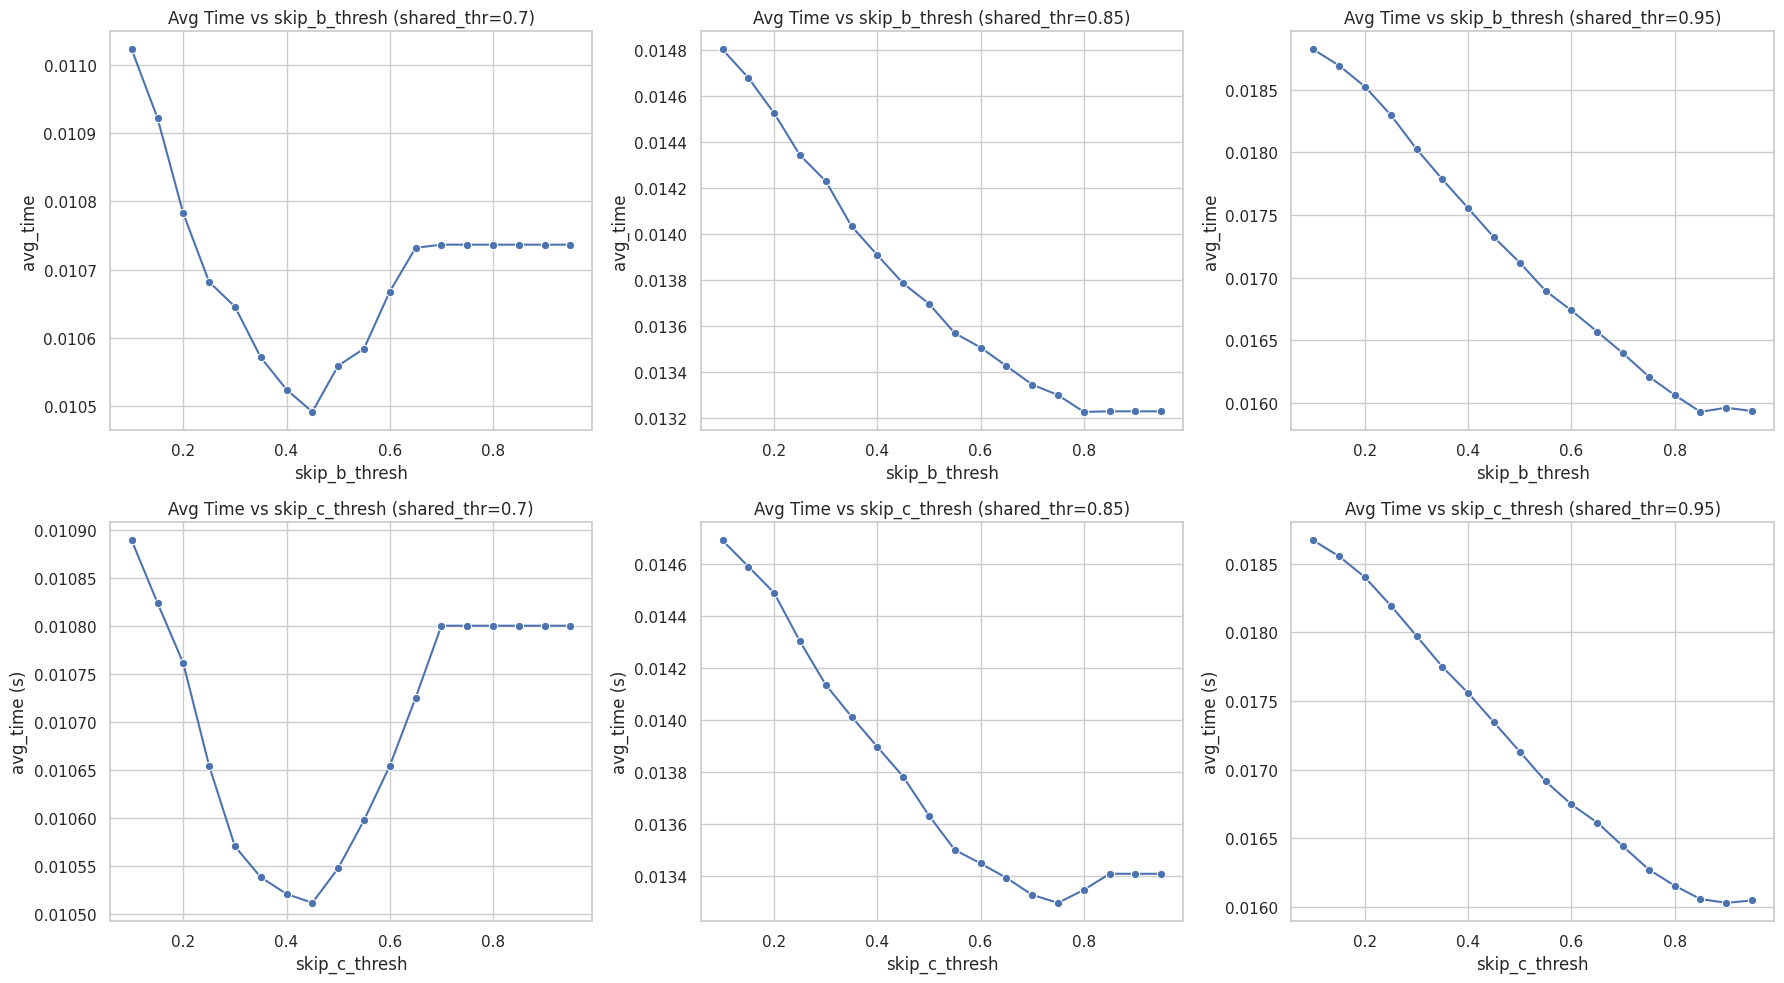

In [17]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure correct column types
df['shared_thr'] = df['shared_thr'].astype(float)

# Select thresholds to plot
conf_levels = [0.70, 0.85, 0.95]

# seaborn theme
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Plot 1,2,3: skip_b_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 1)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_b_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_b_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_b_thresh (shared_thr={conf})')
    plt.xlabel('skip_b_thresh')
    plt.ylabel('avg_time')

# Plot 4,5,6: skip_c_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 4)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_c_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_c_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_c_thresh (shared_thr={conf})')
    plt.xlabel('skip_c_thresh')
    plt.ylabel('avg_time (s)')

plt.tight_layout()
plt.show()

In [ ]:
#maybe plotting a graph with both skip_b and skip_c thresholds?

In [18]:
# Save full results to CSV
df.to_csv('full_simulation_gridsearch_0.0_to_0.95_shared_conf.csv', index=False)
print("Saved full grid results to 'full_simulation_gridsearch_0.0_to_0.95_shared_conf.csv'")

Saved full grid results to 'full_simulation_gridsearch_0.0_to_0.95_shared_conf.csv'


In [19]:
# Download CSV to local machine (in Colab)
from google.colab import files
files.download('full_simulation_gridsearch_0.0_to_0.95_shared_conf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>